# Fitting for $e$ and $w$

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.constants as c
from tqdm import tqdm
import PyAstronomy.pyasl as pya

import photoeccentric as ph
import emcee
import corner

np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [10, 5]

In [112]:
def get_T23(p, rp_earth, rs, T14, a, i):
    
    ing_eg = pya.ingressDuration(a, rp_earth*11.2, rs, i, p)#rp needs to in jovian radii
    print(pya.ingressDuration(a, rp_earth*11.2, rs, i, p))
    T23 = T14-ing_eg
    
    return T23

def get_T23_errs(T23_dist):
    
    x, cdf = ph.get_cdf(T23_dist)
    T23_sigma_minus = ph.find_sigma(x, cdf, "-")
    T23_sigma_plus = ph.find_sigma(x, cdf, "+")
    
    return T23_sigma_minus, T23_sigma_plus


def get_planet_params(p, T14, T23):
    """Returns planet parameters in correct units.

    Parameters
    ----------
    p: float
        Planet orbital period (days)
    rp_earth: float
        Planet radius (earth radii)
    rs: float
        Stellar radius (solar radii)
    T14: float
        Total transit time - first to fourth contact (hours)
    a: float
        Planet semi-major axis (AU)
    i: float
        Orbital inclination (degrees)

    Returns
    -------
    p_seconds: float
        Orbital period (seconds)
    rprs: float
        Planet radius (stellar host radii)
    T14_seconds: float
        Total transit time - first to fourth contact (seconds)
    T23_seconds: float
        Full transit time - second to third contact (seconds)
    """

    p_seconds = p*86400
    T14_seconds = T14*3600
    T23_seconds = T23*3600

    return p_seconds, T14_seconds, T23_seconds


def get_rho_circ(rprs, T14, T23, p):
    """Returns stellar density, assuming a perfectly circular planetary orbit.

    Parameters
    ----------
    rprs: float
        Planet radius (stellar host radii)
    T14: float
        Total transit time - first to fourth contact (seconds)
    T23: float
        Full transit time - second to third contact (seconds)
    p: float
        Orbital period (seconds)

    Returns
    -------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    """
    
    delta = rprs**2
    num1 = 2*(delta**(0.25))
    den1 = np.sqrt((T14**2)-(T23**2))
    term1 = (num1/den1)**3

    num2 = 3*p
    den2 = c.G*(c.pi**2)
    term2 = num2/den2

    rho_circ = term1*term2
    
    return rho_circ


def get_g(rho_circ, rho_star):
    """Gets g

    Parameters
    ----------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    rho_star: float
        Stellar density, calculated from Kepler/Gaia/spectroscopy (kg/m^3)

    Returns
    -------
    g: float
        Cube root of ratio between rho_circ and rho_star
    """
    g = np.cbrt(rho_circ/rho_star)
    return g

def get_g_from_def(e, w):
    """Gets g from e and omega

    Parameters
    ----------
    e: float
        Eccentricity
    w: float
        Angle of periapse or something

    Returns
    -------
    g: float
        Cube root of ratio between rho_circ and rho_star
    """ 
    g = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    return g


def get_e(g, w):
    """Gets eccentricity (from photoeccentric effect)

    Parameters
    ----------
    g: float
        Cube root of ratio between rho_circ and rho_star
    w: float
        Angle of apoapse or periapse (?) (degrees, -90 < w < 90)

    Returns
    -------
    e: float
        Eccentricity of planet orbit
    """
    e = (np.sqrt(2)*(np.sqrt(2*g**4 - g**2*np.cos(2*w) - g**2 - 2*np.sin(w*(np.pi/180.)))))/(2*(g**2 + np.sin(w*(np.pi/180.)**2)))
    return e

1. Read in rhos for all Kepler stars with planets (with spectroscopy)
2. Read in all Kepler stars with planets (from exoplanet archive)
3. Take data from (2) for stars in (1)

In [113]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [114]:
spectplanets = spectplanets.reset_index()

In [115]:
def row_to_top(df, index):
    """Bring row to top
    
    Parameters
    ----------
    df: pandas.dataframe
        Dataframe to copy
    index: int
        Index of row to bring to top
        
    Returns
    -------
    df_cp: pandas.dataframe
        Copy of dataframe with specified row at top
    
    """
    df_cp = pd.concat([df.iloc[[index],:], df.drop(index, axis=0)], axis=0)
    return df_cp

In [129]:

def get_g_distribution(row, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    targ = spectplanets.iloc[row]
    print('KIC: ', targ.kepid)

    rhos = rho_lum[str(targ.kepid)].dropna()
    rhos = np.array(rhos)

    while len(rhos) > n_rhos:
        rhos = np.delete(rhos, [np.random.randint(0, len(rhos))])

    #ws = np.arange(-90., 300., 1.)

    gs = np.zeros((len(rhos)))
    #es = np.zeros(len(rhos))
    #es = np.zeros((len(ws), len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = ph.asymmetric_gaussian(targ.koi_period, targ.koi_period_err1, targ.koi_period_err2, len(rhos))
    
    rs_dist = ph.asymmetric_gaussian(targ.koi_srad, targ.koi_srad_err1, targ.koi_srad_err2, len(rhos))
    rp_earth_dist = ph.asymmetric_gaussian(targ.koi_prad, targ.koi_prad_err1, targ.koi_prad_err2, len(rhos))
    rprs_dist = ph.asymmetric_gaussian(targ.koi_ror, targ.koi_ror_err1, targ.koi_ror_err2, len(rhos))

    T14_dist = ph.asymmetric_gaussian(targ.koi_duration, targ.koi_duration_err1, targ.koi_duration_err2, len(rhos))

    a = targ.koi_sma
    i = targ.koi_incl

    for j in tqdm(range(len(rhos))): #for element in histogram for star:
        
        per_dist[j] = per_dist[j]*86400.
        T14_dist[j] = T14_dist[j]*3600.
        
        print(per_dist[j])
        
        T23_dist[j] = get_T23(per_dist[j], rp_earth_dist[j], rs_dist[j], T14_dist[j], a, i)#Period and T14 need to be in seconds. Then T23 will be in seconds.
        
        rho_circ[j] = get_rho_circ(rprs_dist[j], T14_dist[j], T23_dist[j], per_dist[j])

        print(T14_dist[j], T23_dist[j], per_dist[j])

        
        rho_ratios[j] = rho_circ[j]/rhos[j]
        g = get_g(rho_circ[j], rhos[j])
        gs[j] = g

    return gs
    

In [118]:
spectplanets

,level_0,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,0,64,11923270,K00781.01,Kepler-676 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,-0.03,0.082,0.066,0.095,0.29,0.110,0.628,0.080,0.690,0.086
1,1,85,4139816,K00812.02,Kepler-235 d,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,-0.03,0.140,0.030,0.140,-0.18,0.140,-0.150,0.140,0.230,0.140
2,2,86,4139816,K00812.03,Kepler-235 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,0.04,0.220,0.080,0.210,-0.25,0.170,-0.060,0.160,0.260,0.170
3,3,88,4139816,K00812.04,Kepler-235 c,CONFIRMED,Done,8/16/18,CANDIDATE,0.994,...,-0.45,0.390,0.550,0.350,0.11,0.300,-0.580,0.430,0.590,0.400
4,4,105,4139816,K00812.01,Kepler-235 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,0.05,0.097,0.060,0.110,-0.15,0.092,-0.039,0.092,0.154,0.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,92,7186,5384713,K03444.04,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.000,...,1.20,0.720,1.210,0.730,0.21,0.930,1.570,0.890,1.580,0.910
93,93,7588,10122538,K02926.03,Kepler-1388 d,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,-0.06,0.190,0.140,0.210,-0.10,0.100,-0.180,0.230,0.210,0.210
94,94,7606,10122538,K02926.04,Kepler-1388 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,...,0.15,0.220,0.250,0.220,-0.02,0.220,0.000,0.200,0.020,0.220
95,95,8590,11129738,K01427.02,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.891,...,1.05,0.460,1.140,0.460,-0.35,0.460,0.810,0.460,0.880,0.460


In [84]:
gs_11923270 = get_g_distribution(0, 500)
gs_4139816d = get_g_distribution(1, 500)
gs_6435936 = get_g_distribution(5, 500)

KIC:  11923270


KeyboardInterrupt: 

In [21]:
gs_7907423 = get_g_distribution(6, 500)

KIC:  7907423


100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


In [22]:
gs_4139816e = get_g_distribution(2, 200)
gs_4139816c = get_g_distribution(3, 200)

KIC:  4139816


100%|██████████| 200/200 [00:22<00:00,  8.88it/s]


KIC:  4139816


100%|██████████| 200/200 [00:22<00:00,  8.90it/s]


KIC:  4139816


100%|██████████| 200/200 [00:22<00:00,  8.78it/s]


In [ ]:
ing_eg = 2*pya.ingressDuration(a, rp_earth*11.2, rs, i, p)#rp needs to in jovian radii

In [ ]:
T23 = T14-ing_eg

In [119]:
gs_4139816b = get_g_distribution(4, 200)

KIC:  4139816


  0%|          | 1/200 [00:00<01:37,  2.04it/s]

6589.503226723851
6904.334338105181 314.8311113813297 288595.01520065166


  1%|          | 2/200 [00:01<01:39,  1.99it/s]

6883.487068499443
6706.49162212184 -176.995446377603 288595.20187059767


  2%|▏         | 3/200 [00:01<01:38,  1.99it/s]

7058.10656808963
6839.081192063696 -219.02537602593384 288595.0772660291


  2%|▏         | 4/200 [00:01<01:35,  2.05it/s]

6625.980484399417
7110.923589619434 484.94310522001706 288594.8833034902


  2%|▎         | 5/200 [00:02<01:53,  1.72it/s]

6361.097282331798
6689.064243410156 327.9669610783585 288594.4628860939


  3%|▎         | 6/200 [00:03<01:50,  1.76it/s]

6241.688546827476
6902.141442569261 660.4528957417851 288594.9231324015


  4%|▎         | 7/200 [00:03<01:37,  1.98it/s]

6043.968642870436
7092.675156973322 1048.706514102886 288594.74982009776


  4%|▍         | 8/200 [00:04<01:53,  1.69it/s]

6945.634104557842
6776.371836968898 -169.26226758894427 288594.9786929423


  4%|▍         | 9/200 [00:05<01:55,  1.66it/s]

7530.177023438859
6933.720938070094 -596.4560853687644 288594.9938082989


  5%|▌         | 10/200 [00:05<01:52,  1.69it/s]

5967.878148693111
6863.630397265434 895.752248572323 288594.71728798625


  6%|▌         | 11/200 [00:06<01:50,  1.71it/s]

6063.254481100191
6863.593220973577 800.3387398733867 288594.85885060445


  6%|▌         | 12/200 [00:06<01:48,  1.73it/s]

6412.525393727189
6702.365899365923 289.8405056387337 288594.9383710108


  6%|▋         | 13/200 [00:07<01:57,  1.60it/s]

6755.625896821754
6833.297812305907 77.67191548415303 288594.958451714


  7%|▋         | 14/200 [00:08<01:51,  1.67it/s]

6420.558659978849
7109.335758194156 688.777098215307 288595.0463510252


  8%|▊         | 15/200 [00:08<01:45,  1.76it/s]

6801.112382818337
6875.197162968325 74.08478014998764 288594.87019701523


  8%|▊         | 16/200 [00:08<01:33,  1.97it/s]

6267.086833387568
6850.0290618742765 582.9422284867087 288594.95132685


  8%|▊         | 17/200 [00:09<01:20,  2.27it/s]

6865.230139269535
6944.213481740974 78.98334247143885 288594.8368419974


  9%|▉         | 18/200 [00:09<01:11,  2.55it/s]

6237.220862755787
6881.504790420275 644.2839276644881 288595.11153336643


 10%|▉         | 19/200 [00:09<01:01,  2.92it/s]

6195.670780285022
6838.813401110979 643.1426208259563 288595.24477722787


 10%|█         | 20/200 [00:10<01:01,  2.92it/s]

6596.33561556668
6754.274757346182 157.93914177950228 288595.09177714516


 10%|█         | 21/200 [00:10<00:58,  3.08it/s]

6492.736596642866
6945.187673396096 452.45107675323015 288595.0922512325


 11%|█         | 22/200 [00:10<00:52,  3.40it/s]

6637.786034682264
6921.673584519463 283.887549837199 288594.71862880525


 12%|█▏        | 23/200 [00:10<00:49,  3.58it/s]

7073.483803122685
7008.596485619229 -64.88731750345596 288594.7019161215


 12%|█▏        | 24/200 [00:11<00:47,  3.67it/s]

7398.80810035909
6745.310191634018 -653.4979087250713 288594.9659261135


 12%|█▎        | 25/200 [00:11<00:50,  3.47it/s]

6499.419994657525
7005.756354796538 506.33636013901287 288595.3732345307


 13%|█▎        | 26/200 [00:11<00:46,  3.73it/s]

6719.1005814154405
6641.649337670831 -77.4512437446092 288594.3856023625


 14%|█▎        | 27/200 [00:11<00:44,  3.86it/s]

6375.842692806232
6854.796362408449 478.9536696022169 288595.138653887


 14%|█▍        | 28/200 [00:12<00:43,  3.98it/s]

5759.786257429968
7012.078508344119 1252.2922509141508 288595.13682096946


 14%|█▍        | 29/200 [00:12<00:42,  4.06it/s]

5752.142302888738
6892.504347164989 1140.3620442762503 288595.1500732142


 15%|█▌        | 30/200 [00:12<00:40,  4.15it/s]

6283.8276446730415
6872.955050254949 589.1274055819076 288594.7807403524


 16%|█▌        | 31/200 [00:12<00:39,  4.25it/s]

6056.800348628724
6952.693972060362 895.8936234316379 288595.0022765361


 16%|█▌        | 32/200 [00:12<00:38,  4.33it/s]

6175.418738139206
6944.848425558347 769.4296874191414 288594.9852447594


 16%|█▋        | 33/200 [00:13<00:39,  4.28it/s]

5709.800388396132
6845.7863106633795 1135.9859222672476 288595.3150260506


 17%|█▋        | 34/200 [00:13<00:58,  2.82it/s]

6564.2130717883965
6874.771673023385 310.5586012349886 288595.0324836865


 18%|█▊        | 35/200 [00:14<01:04,  2.56it/s]

6373.39712223954
7037.55239318511 664.15527094557 288594.9837157551


 18%|█▊        | 36/200 [00:14<01:09,  2.35it/s]

6516.688553290198
6707.934938051696 191.24638476149812 288594.78882565384


 18%|█▊        | 37/200 [00:15<01:00,  2.70it/s]

6382.510255955602
7006.008577286554 623.4983213309524 288595.21338588075


 19%|█▉        | 38/200 [00:15<01:03,  2.55it/s]

6593.506729941051
6719.921618309408 126.41488836835651 288595.07774316176


 20%|█▉        | 39/200 [00:15<01:00,  2.67it/s]

6467.204170559786
6967.221932190358 500.01776163057184 288595.19509179535


 20%|██        | 40/200 [00:16<00:52,  3.05it/s]

6479.783752123533
6946.336964035118 466.5532119115851 288595.15291347075


 20%|██        | 41/200 [00:16<00:46,  3.38it/s]

5934.625714468039
6786.183617618353 851.5579031503139 288594.871679465


 21%|██        | 42/200 [00:16<00:45,  3.49it/s]

7424.136694034428
6868.4112587156005 -555.7254353188273 288594.89358388557


 22%|██▏       | 43/200 [00:16<00:42,  3.69it/s]

6693.319904753193
6809.962238519165 116.64233376597167 288594.4413025835


 22%|██▏       | 44/200 [00:17<00:42,  3.68it/s]

6349.262608201098
6822.9814804304715 473.7188722293731 288595.14896179206


 22%|██▎       | 45/200 [00:17<00:44,  3.48it/s]

6063.590187692923
6759.574378408929 695.9841907160062 288594.53671352507


 23%|██▎       | 46/200 [00:17<00:41,  3.72it/s]

5956.619643148169
6763.191883912355 806.5722407641852 288594.82841523347


 24%|██▎       | 47/200 [00:17<00:41,  3.68it/s]

6671.0859555207635
7045.739066289401 374.6531107686378 288594.8875127974


 24%|██▍       | 48/200 [00:18<00:39,  3.81it/s]

7234.316708319977
6807.961478889483 -426.35522943049364 288594.4404935355


 24%|██▍       | 49/200 [00:18<00:42,  3.55it/s]

6520.0823165151205
6965.303567983183 445.2212514680623 288594.6407284853


 25%|██▌       | 50/200 [00:18<00:40,  3.73it/s]

6551.461911602095
6824.9306158200225 273.46870421792755 288594.70906853786


 26%|██▌       | 51/200 [00:18<00:38,  3.89it/s]

6679.477620665143
7042.582265399546 363.1046447344024 288594.61244542804


 26%|██▌       | 52/200 [00:19<00:41,  3.59it/s]

6528.47855817038
6752.555770808326 224.0772126379461 288594.5041506667


 26%|██▋       | 53/200 [00:19<00:39,  3.71it/s]

5976.657221316596
6855.941482788302 879.2842614717056 288595.3303843177


 27%|██▋       | 54/200 [00:19<00:37,  3.93it/s]

6581.28399133752
6778.991581308435 197.70758997091525 288594.75980321533


 28%|██▊       | 55/200 [00:19<00:35,  4.11it/s]

6335.334119943932
6819.157942426566 483.82382248263366 288594.5560641911


 28%|██▊       | 56/200 [00:20<00:35,  4.07it/s]

6695.319019450246
6745.262224696951 49.943205246705475 288595.2339692622


 28%|██▊       | 57/200 [00:20<00:37,  3.82it/s]

6685.145264051185
6819.907350053576 134.7620860023908 288595.42679628695


 29%|██▉       | 58/200 [00:20<00:38,  3.68it/s]

6698.145706539735
6968.573734505051 270.4280279653158 288595.1700123901


 30%|██▉       | 59/200 [00:21<00:36,  3.85it/s]

5577.734453587513
6784.7833664903965 1207.0489129028838 288594.5495626652


 30%|███       | 60/200 [00:21<00:38,  3.63it/s]

6678.638822287381
6656.73519348736 -21.90362880002067 288594.9404088297


 30%|███       | 61/200 [00:21<00:38,  3.57it/s]

6432.805570546938
6886.15884234992 453.3532718029819 288594.7263184353


 31%|███       | 62/200 [00:21<00:37,  3.68it/s]

5268.164923901528
6913.470703169769 1645.3057792682412 288594.9070543891


 32%|███▏      | 63/200 [00:22<00:39,  3.50it/s]

6686.856053850202
7004.187600613085 317.3315467628827 288594.9181635527


 32%|███▏      | 64/200 [00:22<00:38,  3.51it/s]

6644.761885272137
6842.473771660936 197.71188638879903 288594.50764264166


 32%|███▎      | 65/200 [00:22<00:40,  3.37it/s]

6502.996875300298
6882.688051800482 379.69117650018416 288594.503879974


 33%|███▎      | 66/200 [00:23<00:36,  3.63it/s]

6295.6157667271755
6863.693537665672 568.0777709384965 288594.5575779238


 34%|███▎      | 67/200 [00:23<00:35,  3.71it/s]

6018.948009709305
6877.059806617041 858.1117969077368 288594.5454504158


 34%|███▍      | 68/200 [00:23<00:36,  3.63it/s]

5352.469178688264
6915.981195570533 1563.5120168822687 288594.6214006926


 34%|███▍      | 69/200 [00:23<00:34,  3.85it/s]

6886.98077287128
6896.722995592824 9.74222272154384 288594.73042834556


 35%|███▌      | 70/200 [00:24<00:32,  3.96it/s]

6873.2918702578645
6854.63828700761 -18.653583250254087 288595.2439682944


 36%|███▌      | 71/200 [00:24<00:31,  4.12it/s]

5565.718270466696
6912.366550575687 1346.6482801089915 288594.5948706839


 36%|███▌      | 72/200 [00:24<00:31,  4.13it/s]

6895.020431869909
6836.439625186676 -58.58080668323328 288594.25782417454


 36%|███▋      | 73/200 [00:24<00:32,  3.94it/s]

7162.37447076015
6804.70207810792 -357.67239265223 288594.8928561795


 37%|███▋      | 74/200 [00:25<00:34,  3.63it/s]

6219.929695596737
6893.647042183145 673.717346586408 288594.717909857


 38%|███▊      | 75/200 [00:25<00:32,  3.81it/s]

6020.58813011638
6959.281221098022 938.693090981642 288595.02959819185


 38%|███▊      | 76/200 [00:25<00:33,  3.73it/s]

6551.240060764374
6927.512297570261 376.2722368058867 288594.49134669255


 38%|███▊      | 77/200 [00:25<00:31,  3.89it/s]

5907.720086702677
6706.944262929644 799.2241762269668 288595.2756475721


 39%|███▉      | 78/200 [00:26<00:31,  3.84it/s]

6547.360444922787
7000.389027851987 453.02858292919973 288595.0716208589


 40%|███▉      | 79/200 [00:26<00:33,  3.63it/s]

7193.8771946062125
6881.258672786945 -312.6185218192677 288594.8131149505


 40%|████      | 80/200 [00:26<00:35,  3.39it/s]

6051.275230137356
7052.208938541073 1000.933708403717 288594.8814638656


 40%|████      | 81/200 [00:27<00:36,  3.28it/s]

6391.498605501278
6822.184095461793 430.68548996051504 288595.00217851036


 41%|████      | 82/200 [00:27<00:35,  3.36it/s]

6791.7476187397515
6929.0717155789 137.3240968391483 288595.04011642217


 42%|████▏     | 83/200 [00:27<00:31,  3.67it/s]

5788.587579546493
6875.571146717544 1086.9835671710516 288594.8625367751


 42%|████▏     | 84/200 [00:27<00:29,  3.88it/s]

6592.063178251572
6875.509336282871 283.4461580312991 288594.6850631464


 42%|████▎     | 85/200 [00:28<00:28,  4.05it/s]

6957.253911806712
6733.366104935001 -223.88780687171038 288594.82163050346


 43%|████▎     | 86/200 [00:28<00:28,  4.00it/s]

6382.199527194761
6814.292196015203 432.09266882044267 288595.19182491186


 44%|████▎     | 87/200 [00:28<00:28,  4.02it/s]

6413.37981778569
6879.497030898859 466.1172131131689 288594.80759046663


 44%|████▍     | 88/200 [00:28<00:27,  4.15it/s]

6945.415447947801
7004.378267809912 58.962819862111246 288594.85472950066


 44%|████▍     | 89/200 [00:29<00:27,  4.07it/s]

6028.006573527289
6959.206810438367 931.2002369110778 288594.4728433032


 45%|████▌     | 90/200 [00:29<00:26,  4.16it/s]

6391.48854381761
6726.760580256554 335.27203643894427 288594.909465917


 46%|████▌     | 91/200 [00:29<00:27,  3.92it/s]

7225.990499385999
7136.060341488812 -89.9301578971872 288594.88221941085


 46%|████▌     | 92/200 [00:29<00:30,  3.54it/s]

5832.599879601548
6738.937030353218 906.3371507516695 288594.9789403395


 46%|████▋     | 93/200 [00:30<00:29,  3.66it/s]

6280.569599992865
6954.24639606825 673.676796075385 288594.47463384276


 47%|████▋     | 94/200 [00:30<00:27,  3.87it/s]

6964.735118083289
6924.505785836134 -40.22933224715507 288594.7324119321


 48%|████▊     | 95/200 [00:30<00:28,  3.69it/s]

6945.031171234096
6905.895382878999 -39.13578835509725 288595.02617942955


 48%|████▊     | 96/200 [00:30<00:26,  3.87it/s]

5609.108136890811
6757.258250021655 1148.1501131308441 288595.1345517188


 48%|████▊     | 97/200 [00:31<00:26,  3.91it/s]

6701.407465037667
6796.0241807187695 94.6167156811025 288594.99087296706


 49%|████▉     | 98/200 [00:31<00:27,  3.75it/s]

6058.988195634136
6719.572657663319 660.5844620291828 288594.67601896747


 50%|████▉     | 99/200 [00:31<00:27,  3.71it/s]

6037.322557696783
6799.023823084115 761.7012653873317 288595.47813488747


 50%|█████     | 100/200 [00:32<00:32,  3.07it/s]

7360.318316789077
6684.028534356161 -676.2897824329157 288594.794889749


 50%|█████     | 101/200 [00:32<00:33,  2.99it/s]

6496.8244327943785
7050.092295369999 553.2678625756207 288594.7091801589


 51%|█████     | 102/200 [00:32<00:30,  3.25it/s]

6300.102583049912
6806.676879631255 506.57429658134333 288594.8921553195


 52%|█████▏    | 103/200 [00:32<00:27,  3.55it/s]

6188.86247843197
6888.04000094194 699.17752250997 288595.12666151306


 52%|█████▏    | 104/200 [00:33<00:25,  3.78it/s]

6473.527557667494
7018.985628387946 545.4580707204523 288594.79659844603


 52%|█████▎    | 105/200 [00:33<00:25,  3.74it/s]

6893.265960223396
7059.758777401273 166.49281717787653 288595.4151367685


 53%|█████▎    | 106/200 [00:33<00:23,  3.97it/s]

6240.694271699403
6740.279848072833 499.58557637343074 288595.2027084945


 54%|█████▎    | 107/200 [00:33<00:22,  4.12it/s]

6378.236585104263
6891.911835853112 513.6752507488491 288595.08240492234


 54%|█████▍    | 108/200 [00:34<00:21,  4.23it/s]

6332.562711455525
6817.489936008648 484.9272245531238 288595.003389507


 55%|█████▍    | 109/200 [00:34<00:22,  4.00it/s]

6615.746610886821
6851.557605630528 235.81099474370694 288595.18812235905


 55%|█████▌    | 110/200 [00:34<00:23,  3.89it/s]

6991.605572349463
7019.36188964491 27.756317295446934 288595.3962078622


 56%|█████▌    | 111/200 [00:35<00:24,  3.58it/s]

6271.216333099707
6830.115148538864 558.8988154391564 288594.6873450199


 56%|█████▌    | 112/200 [00:35<00:28,  3.04it/s]

6184.940670075899
6963.0480228845 778.1073528086008 288594.5151991634


 56%|█████▋    | 113/200 [00:35<00:29,  2.95it/s]

7305.781177016933
6862.011789076452 -443.76938794048056 288595.07242895063


 57%|█████▋    | 114/200 [00:36<00:28,  3.00it/s]

6407.004412197602
6865.9304539641735 458.92604176657187 288594.665855282


 57%|█████▊    | 115/200 [00:36<00:27,  3.15it/s]

6197.586981443639
7051.749349699682 854.162368256043 288595.10180545703


 58%|█████▊    | 116/200 [00:36<00:24,  3.40it/s]

5368.544362565101
7007.437638533954 1638.8932759688523 288594.8785070275


 58%|█████▊    | 117/200 [00:36<00:23,  3.49it/s]

6785.743905978026
6988.016568626909 202.27266264888294 288595.00967500923


 59%|█████▉    | 118/200 [00:37<00:22,  3.64it/s]

6413.7435151499985
6953.009675859194 539.2661607091959 288594.94718458987


 60%|█████▉    | 119/200 [00:37<00:22,  3.61it/s]

6471.741710140062
7109.074933370497 637.3332232304347 288594.536374401


 60%|██████    | 120/200 [00:37<00:22,  3.59it/s]

6381.247840507718
6764.860722787017 383.6128822792989 288594.69103510596


 60%|██████    | 121/200 [00:38<00:21,  3.65it/s]

6505.025629362677
7063.30055619605 558.2749268333728 288594.7393545615


 61%|██████    | 122/200 [00:38<00:22,  3.49it/s]

6380.767770769742
6915.589569055478 534.8217982857359 288595.0784211594


 62%|██████▏   | 123/200 [00:38<00:20,  3.73it/s]

5920.233816463913
6876.241196447236 956.0073799833226 288594.5797431388


 62%|██████▏   | 124/200 [00:38<00:20,  3.71it/s]

6792.558448575259
6734.32398654051 -58.2344620347485 288594.81291823037


 62%|██████▎   | 125/200 [00:39<00:21,  3.47it/s]

6790.897764509072
6655.748857064017 -135.14890744505465 288594.96213142417


 63%|██████▎   | 126/200 [00:39<00:22,  3.30it/s]

6501.6047920732635
6943.3953038333375 441.79051176007397 288594.76478430285


 64%|██████▎   | 127/200 [00:39<00:22,  3.26it/s]

5908.973267191069
7008.019805420181 1099.0465382291122 288594.9468267989


 64%|██████▍   | 128/200 [00:40<00:21,  3.29it/s]

6506.014616746442
6983.254863064286 477.24024631784414 288595.17597965867


 64%|██████▍   | 129/200 [00:40<00:23,  3.07it/s]

6051.567858803213
6811.0258365711 759.4579777678864 288595.1001677867


 65%|██████▌   | 130/200 [00:40<00:24,  2.81it/s]

6723.65923392913
6734.764566535147 11.105332606017328 288595.007745387


 66%|██████▌   | 131/200 [00:41<00:23,  2.98it/s]

5581.456468197072
6864.43542216081 1282.9789539637377 288595.50212594494


 66%|██████▌   | 132/200 [00:41<00:21,  3.12it/s]

6338.585590763365
6810.540738365134 471.95514760176866 288594.23401082435


 66%|██████▋   | 133/200 [00:41<00:20,  3.29it/s]

6363.424901949283
6684.828183964747 321.40328201546436 288594.57621275174


 67%|██████▋   | 134/200 [00:42<00:19,  3.39it/s]

6604.01049651721
6592.459890387162 -11.550606130048436 288595.12307615095


 68%|██████▊   | 135/200 [00:42<00:17,  3.64it/s]

6471.697534683048
6944.0635073892 472.3659727061522 288594.79126567533


 68%|██████▊   | 136/200 [00:42<00:17,  3.58it/s]

7315.688404832334
6871.806752760468 -443.8816520718656 288595.2674306597


 68%|██████▊   | 137/200 [00:42<00:17,  3.64it/s]

5956.3748169356095
6831.107105338704 874.7322884030946 288594.5083208479


 69%|██████▉   | 138/200 [00:43<00:17,  3.50it/s]

6739.25319507301
7123.886078780623 384.6328837076135 288595.3308617436


 70%|██████▉   | 139/200 [00:43<00:19,  3.12it/s]

6436.791839760759
6676.729063769182 239.93722400842307 288594.5568996156


 70%|███████   | 140/200 [00:44<00:24,  2.47it/s]

6274.4057869306125
7024.458595420727 750.0528084901143 288594.5943624477


 70%|███████   | 141/200 [00:44<00:25,  2.33it/s]

6601.464350158723
6888.80960221753 287.3452520588062 288594.7147869697


 71%|███████   | 142/200 [00:45<00:26,  2.23it/s]

5967.113813737074
6938.645118871264 971.5313051341891 288595.2195254023


 72%|███████▏  | 143/200 [00:45<00:26,  2.19it/s]

5720.079330719732
6966.4333102051905 1246.3539794854587 288595.08209597704


 72%|███████▏  | 144/200 [00:46<00:25,  2.21it/s]

6489.3745294524415
6748.077027774398 258.7024983219562 288594.6937944688


 72%|███████▎  | 145/200 [00:46<00:26,  2.10it/s]

6374.079820763622
6922.909896799487 548.8300760358652 288594.83725211443


 73%|███████▎  | 146/200 [00:46<00:24,  2.18it/s]

6234.723923338026
6737.906876329726 503.1829529917004 288594.9611228511


 74%|███████▎  | 147/200 [00:47<00:25,  2.06it/s]

6506.143719161934
6800.962914542894 294.8191953809601 288595.02447792096


 74%|███████▍  | 148/200 [00:48<00:25,  2.00it/s]

6994.647107903604
6722.937656005052 -271.7094518985514 288594.51573974965


 74%|███████▍  | 149/200 [00:48<00:24,  2.09it/s]

6776.171847454331
6698.63537931622 -77.53646813811156 288595.1594715968


 75%|███████▌  | 150/200 [00:48<00:22,  2.20it/s]

6498.220277906681
6931.354461766309 433.13418385962814 288594.3713661349


 76%|███████▌  | 151/200 [00:49<00:20,  2.34it/s]

6271.051530951819
6756.505395204084 485.4538642522657 288594.96929098177


 76%|███████▌  | 152/200 [00:50<00:26,  1.82it/s]

6220.774644330579
6875.439912923269 654.6652685926902 288594.6541569825


 76%|███████▋  | 153/200 [00:50<00:26,  1.79it/s]

6441.002495816945
7115.565831383189 674.563335566244 288594.95731759013


 77%|███████▋  | 154/200 [00:51<00:25,  1.83it/s]

6441.04899747425
6689.387545121607 248.3385476473568 288594.8737603069


 78%|███████▊  | 155/200 [00:51<00:23,  1.93it/s]

6481.0440412606495
7048.175033503411 567.1309922427617 288594.6489705309


 78%|███████▊  | 156/200 [00:51<00:19,  2.30it/s]

6271.978558200781
6813.766308231605 541.7877500308241 288594.6982125389


 78%|███████▊  | 157/200 [00:52<00:18,  2.27it/s]

7066.626548573773
6943.400871211967 -123.22567736180645 288595.1853717094


 79%|███████▉  | 158/200 [00:52<00:18,  2.29it/s]

6915.813279567574
6852.268297608269 -63.544981959305005 288594.45671900496


 80%|███████▉  | 159/200 [00:53<00:17,  2.33it/s]

6836.53708849829
6978.379408879518 141.8423203812281 288595.08285312407


 80%|████████  | 160/200 [00:53<00:16,  2.40it/s]

6321.430501225163
7009.301978480776 687.8714772556123 288594.8750515647


 80%|████████  | 161/200 [00:53<00:15,  2.57it/s]

6020.551862311086
6773.866300022529 753.3144377114431 288595.0327925765


 81%|████████  | 162/200 [00:54<00:13,  2.79it/s]

6298.983372273565
6883.038233820297 584.0548615467324 288594.9296399501


 82%|████████▏ | 163/200 [00:54<00:12,  3.06it/s]

6201.789136453063
7042.224206765309 840.4350703122454 288594.8481357266


 82%|████████▏ | 164/200 [00:55<00:15,  2.38it/s]

6373.979781930044
6982.39448461368 608.4147026836363 288594.8203767548


 82%|████████▎ | 165/200 [00:55<00:14,  2.50it/s]

6347.474216979777
6795.6657236828705 448.1915067030932 288595.01178112184


 83%|████████▎ | 166/200 [00:56<00:15,  2.15it/s]

6970.6000355766355
6963.4212885118395 -7.178747064795971 288595.1628611285


 84%|████████▎ | 167/200 [00:56<00:13,  2.39it/s]

6950.511443546713
6687.005850743215 -263.5055928034981 288595.37554449425


 84%|████████▍ | 168/200 [00:56<00:11,  2.68it/s]

6546.128402576891
6915.398271747121 369.26986917022987 288594.5549474369


 84%|████████▍ | 169/200 [00:56<00:10,  2.88it/s]

6793.27287677233
6778.773786382871 -14.499090389459525 288594.8495631419


 85%|████████▌ | 170/200 [00:57<00:09,  3.03it/s]

7781.931359589123
6890.770692143458 -891.1606674456643 288594.33619936317


 86%|████████▌ | 171/200 [00:57<00:09,  2.95it/s]

6543.420849739597
6933.068666701634 389.6478169620377 288594.89017065393


 86%|████████▌ | 172/200 [00:58<00:10,  2.60it/s]

6078.24192094671
6897.315719671966 819.073798725256 288594.6588788146


 86%|████████▋ | 173/200 [00:58<00:10,  2.60it/s]

6241.6109056785535
6884.373555263223 642.7626495846698 288595.1154927934


 87%|████████▋ | 174/200 [00:58<00:09,  2.64it/s]

6488.852970349694
6788.169630218391 299.31665986869666 288594.8422581114


 88%|████████▊ | 175/200 [00:59<00:09,  2.77it/s]

6156.956401306606
7085.42817784231 928.4717765357045 288595.402165506


 88%|████████▊ | 176/200 [00:59<00:07,  3.05it/s]

6465.824051402266
7093.4033607070405 627.5793093047741 288595.12359410035


 88%|████████▊ | 177/200 [00:59<00:06,  3.36it/s]

6198.890546058579
6852.440342290544 653.549796231965 288594.8530668139


 89%|████████▉ | 178/200 [00:59<00:06,  3.40it/s]

6060.472319030097
6963.864147558788 903.3918285286909 288595.0175732401


 90%|████████▉ | 179/200 [01:00<00:05,  3.62it/s]

5841.776706702075
6840.644856574831 998.8681498727556 288594.9421000327


 90%|█████████ | 180/200 [01:00<00:05,  3.51it/s]

6632.797742928766
6723.117932394685 90.32018946591961 288594.81107807485


 90%|█████████ | 181/200 [01:00<00:05,  3.54it/s]

6611.835285841116
6903.9299666742645 292.09468083314823 288595.03611229616


 91%|█████████ | 182/200 [01:00<00:05,  3.47it/s]

6218.407014510963
6935.137786391353 716.7307718803904 288595.0656105326


 92%|█████████▏| 183/200 [01:01<00:05,  3.20it/s]

6026.728981570288
6881.785752387706 855.0567708174185 288594.750324409


 92%|█████████▏| 184/200 [01:01<00:05,  3.12it/s]

5681.432424188964
6962.021903562602 1280.589479373638 288594.7902626635


 92%|█████████▎| 185/200 [01:01<00:04,  3.33it/s]

6261.941245075501
7028.0643589488955 766.1231138733947 288594.89701028256


 93%|█████████▎| 186/200 [01:02<00:04,  3.08it/s]

7062.788825369699
6972.709695079033 -90.0791302906664 288594.70529401023


 94%|█████████▎| 187/200 [01:02<00:04,  3.10it/s]

6943.580498919597
6989.051205117488 45.47070619789156 288594.9458792328


 94%|█████████▍| 188/200 [01:02<00:03,  3.15it/s]

6689.8129731408135
6761.705077935364 71.8921047945505 288594.8960853862


 94%|█████████▍| 189/200 [01:03<00:03,  3.30it/s]

6262.59592291642
6830.57111640588 567.9751934894603 288594.35498599947


 95%|█████████▌| 190/200 [01:03<00:03,  3.14it/s]

6597.488714514179
6894.785956567501 297.2972420533215 288595.0784228811


 96%|█████████▌| 191/200 [01:03<00:03,  2.99it/s]

7834.953491949072
6864.498151337488 -970.4553406115838 288594.9809549144


 96%|█████████▌| 192/200 [01:04<00:02,  3.05it/s]

6048.786073576848
6816.480641584387 767.6945680075387 288594.6933143282


 96%|█████████▋| 193/200 [01:04<00:02,  3.35it/s]

6232.927256145873
6911.842530449083 678.91527430321 288595.0615417645


 97%|█████████▋| 194/200 [01:04<00:01,  3.61it/s]

6587.970139625307
6840.26453194756 252.29439232225286 288594.8962622826


 98%|█████████▊| 195/200 [01:04<00:01,  3.61it/s]

6822.365763911311
6825.201843050822 2.8360791395116394 288595.2362793371


 98%|█████████▊| 196/200 [01:05<00:01,  3.70it/s]

5445.7636267268535
6859.278073621016 1413.5144468941626 288595.1137344306


 98%|█████████▊| 197/200 [01:05<00:00,  3.53it/s]

6144.39568288366
6930.194536041773 785.7988531581132 288594.87697879405


 99%|█████████▉| 198/200 [01:05<00:00,  3.56it/s]

6765.6631524644745
6565.736573593266 -199.92657887120822 288595.24459558044


100%|█████████▉| 199/200 [01:06<00:00,  3.62it/s]

7086.901924770522
6964.782119000507 -122.11980577001486 288594.85401223943


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]

6498.037444804436
6901.800002781918 403.7625579774822 288595.33477193327


In [120]:
def get_sigmas(dist):
    """Gets + and - sigmas from a distribution (gaussian or not) through a cdf
    
    Parameters
    ----------
    dist: np.array
        Distribution from which sigmas are needed
        
    Returns
    -------
    sigma_minus: float
        - sigma
    sigma_plus: float
        + sigma
    """
    x, cdf = ph.get_cdf(dist)
    sigma_minus = ph.find_sigma(x, cdf, "-")
    sigma_plus = ph.find_sigma(x, cdf, "+")
    
    return sigma_minus, sigma_plus

In [121]:
sigma_m, sigma_p = get_sigmas(gs_11923270)

sigma_m2, sigma_p2 = get_sigmas(rho_lum['11923270'].dropna())

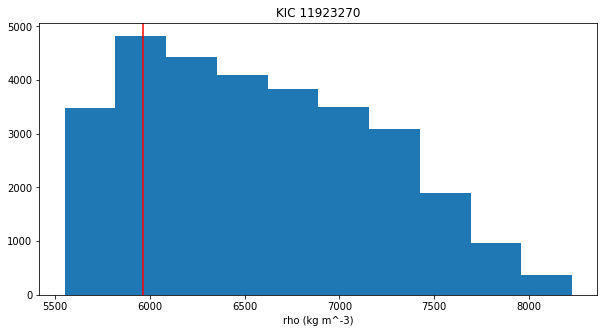

In [122]:
plt.hist(rho_lum['11923270'].dropna());
plt.xlabel('rho (kg m^-3)');
plt.title('KIC 11923270');
plt.axvline(np.mean(rho_lum['11923270'].dropna())+sigma_m2, c='r')

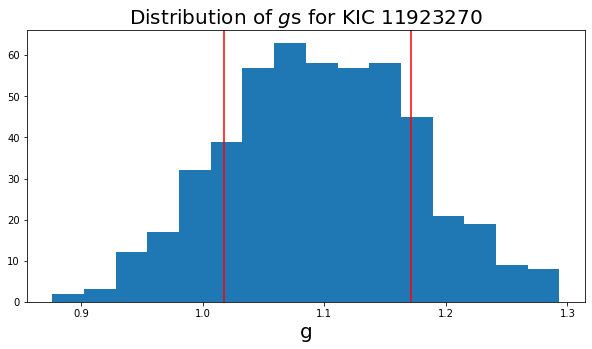

In [123]:
plt.hist(gs_11923270, bins='auto');
plt.xlabel('g', fontsize=20)
plt.title('Distribution of $g$s for KIC 11923270', fontsize=20)
plt.axvline(np.mean(gs_11923270)+sigma_m, c='r')
plt.axvline(np.mean(gs_11923270)+sigma_p, c='r')

In [28]:
def get_e_from_def(g, w):
    """Gets eccentricity from definition (eqn 4, not really the definition tho)
    
    Parameters
    ----------
    g: float
        g value
    w: float
        Omega (angle periapse/apoapse)
    
    Returns
    -------
    e: float
        Eccentricity calculated solely on g and w
    
    """
    num = np.sqrt(2)*np.sqrt(2*g**4-g**2*np.cos(2*w)-g**2-2*np.sin(w*(np.pi/180.)))
    den = 2*(g**2+np.sin(w*(np.pi/180.)**2))
    e = num/den
    return e

## Finding the allowable (e, w) space for one planet with MCMC

In [29]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

In [30]:
def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

In [31]:
def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

## For planet with g = 1.1

In [32]:
#Guesses
w_guess = 100.0
e_guess = 0.95

solnx = (w_guess, e_guess)

In [33]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [34]:
g_mean = np.mean(gs_11923270)
g_sigma = np.mean(np.abs(get_sigmas(gs_11923270)))

#g_mean = 0.4
#g_sigma = 0.05

In [35]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 7000, progress=True);

100%|██████████| 7000/7000 [00:12<00:00, 562.11it/s]


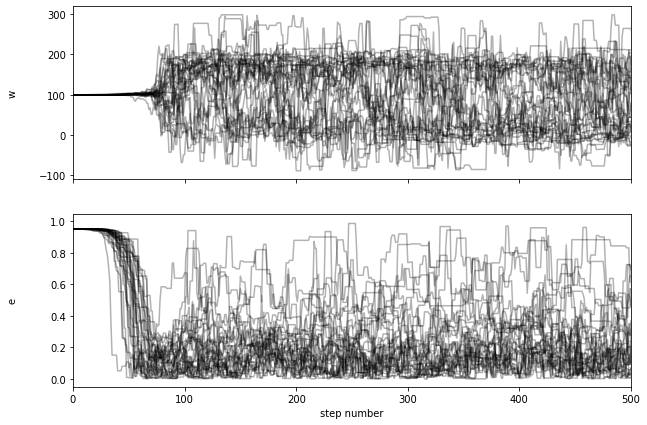

In [36]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

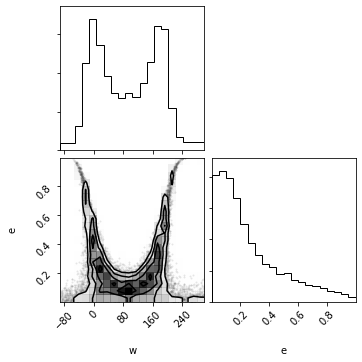

In [37]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

## For planet with g = 0.85

In [38]:
#Guesses
w_guess = 0.0
e_guess = 0.40

solnx = (w_guess, e_guess)

In [39]:
pos = solnx + 1e-4 * np.random.randn(64, 2)
nwalkers, ndim = pos.shape

In [40]:
g_mean = np.mean(gs_6435936)
g_sigma = np.mean(np.abs(get_sigmas(gs_6435936)))

In [41]:
g_mean

0.8564137779883652

In [42]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:33<00:00, 299.42it/s]


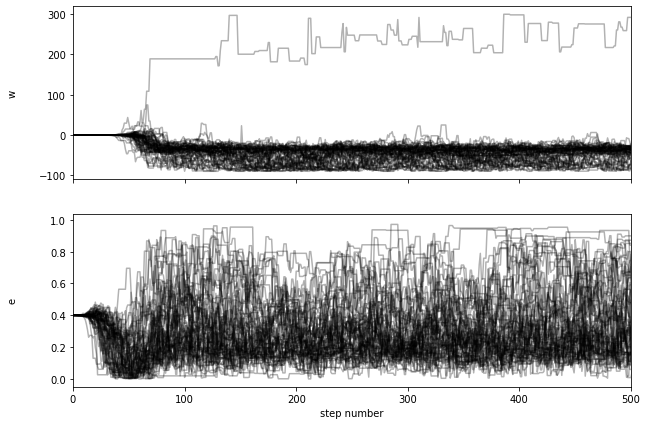

In [43]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

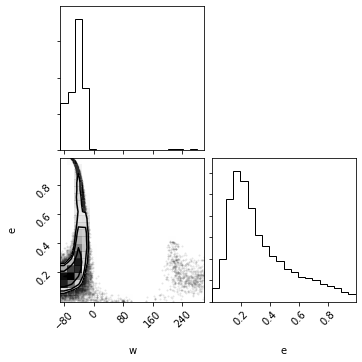

In [44]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

## For planet with g = 0.75

In [45]:
#Guesses
w_guess = 100.0
e_guess = 0.55

solnx = (w_guess, e_guess)

In [46]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [47]:
g_mean = np.mean(gs_7907423)
g_sigma = np.mean(np.abs(get_sigmas(gs_7907423)))

In [48]:
g_mean

0.7482813788108342

In [49]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:19<00:00, 525.91it/s]


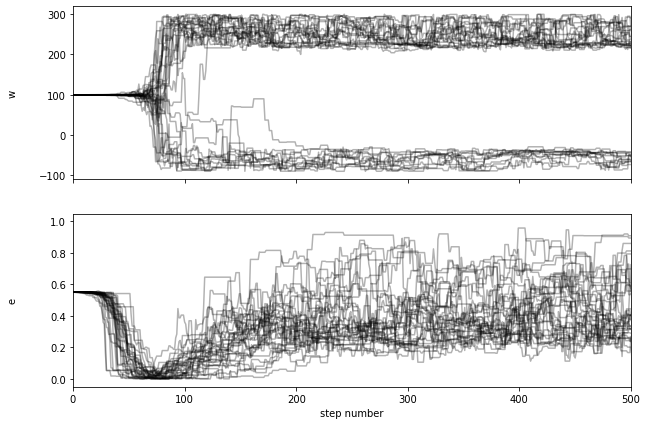

In [50]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

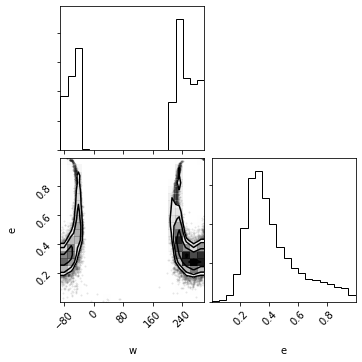

In [51]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

# A 4-planet system: 4139816

## 4139816b

g=0.9

In [130]:
#Guesses
w_guess = 100.0
e_guess = 0.55

solnx = (w_guess, e_guess)

In [131]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [132]:
g_mean = np.mean(gs_4139816b)
g_sigma = np.mean(np.abs(get_sigmas(gs_4139816b)))

In [133]:
g_mean

0.8930877345612176

In [134]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████| 8000/8000 [00:12<00:00, 628.05it/s]


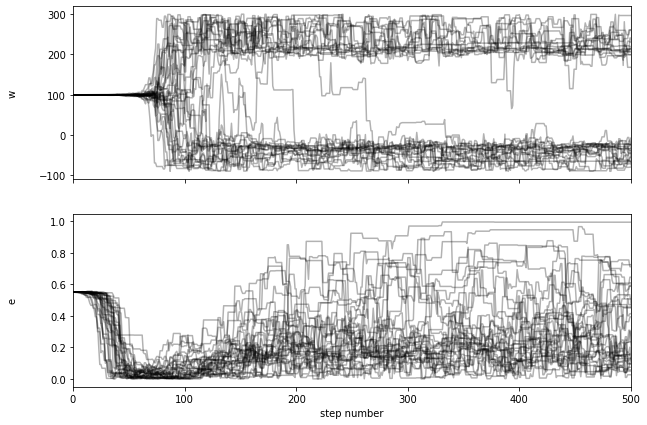

In [135]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

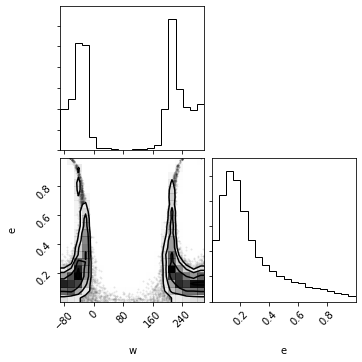

In [136]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

## 4139816c

g=0.73

In [60]:
#Guesses
w_guess = 100.0
e_guess = 0.55

solnx = (w_guess, e_guess)

In [61]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [62]:
g_mean = np.mean(gs_4139816c)
g_sigma = np.mean(np.abs(get_sigmas(gs_4139816c)))

In [63]:
g_mean

0.7356006724492415

In [64]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████| 8000/8000 [00:16<00:00, 491.10it/s]


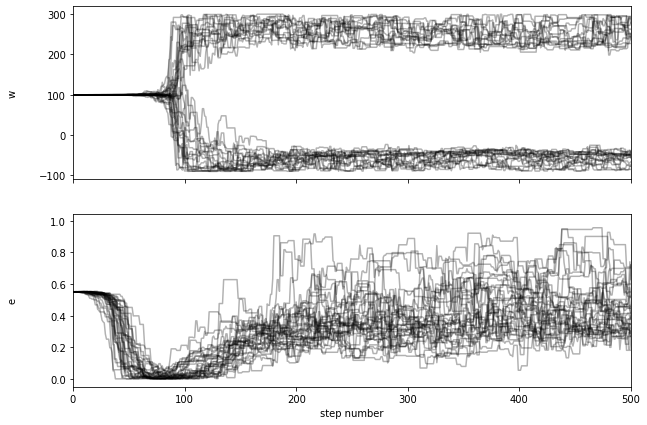

In [65]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

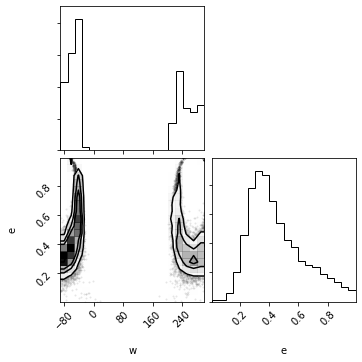

In [66]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

## 4139816d
g = 0.9

In [67]:
#Guesses
w_guess = 100.0
e_guess = 0.55

solnx = (w_guess, e_guess)

In [68]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [69]:
g_mean = np.mean(gs_4139816d)
g_sigma = np.mean(np.abs(get_sigmas(gs_4139816d)))

In [70]:
g_mean

0.913167532905489

In [71]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████| 8000/8000 [00:16<00:00, 489.90it/s]


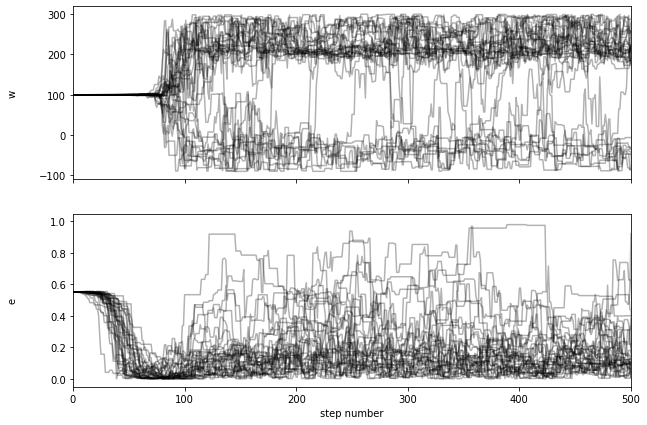

In [72]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

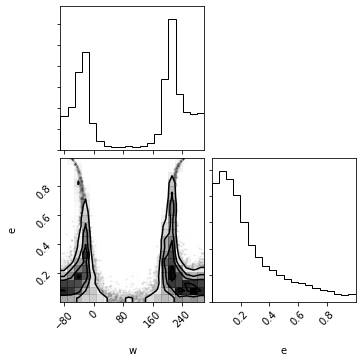

In [73]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

## 4139816e
g=0.86

In [124]:
#Guesses
w_guess = 50.0
e_guess = 0.3

solnx = (w_guess, e_guess)

In [125]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [126]:
g_mean = np.mean(gs_4139816e)
g_sigma = np.mean(np.abs(get_sigmas(gs_4139816e)))

In [127]:
g_mean

0.8687199000144128

In [128]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:22<00:00, 449.42it/s]


In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

#### Graph of g from (e, w) meshgrid

In [ ]:
e = np.linspace(0.0, 1.0, num=500)
w = np.linspace(-90.0, 300.0, num=500)
W, E = np.meshgrid(w, e)

In [ ]:
G = get_g_from_def(E, W)

In [ ]:
from matplotlib import ticker, cm

In [ ]:
plt.contourf(W, E, G, levels=200, locator=ticker.LogLocator(), cmap='Blues')
plt.colorbar()

In [ ]:
fig, ax = plt.subplots()
CS = ax.contourf(W, E, G, levels=100)
ax.set_ylabel('e');
ax.set_xlabel('w (degrees)')

In [ ]:
for i in range(len(G)):
    for j in range(len(G[0])):
        if 0.7 < G[i][j] < 1.3:
            G[i][j] = 1.
        else:
            G[i][j] = 0.

In [ ]:
fig, ax = plt.subplots()
CS = ax.contourf(W, E, G)
#ax.clabel(CS, inline=True, fontsize=10)
ax.set_ylabel('e');
ax.set_xlabel('w (degrees)')
ax.set_title('g = 1.0 +/- 0.2');

😈

Create a transit with e, see if you can get it back out with above code ^

https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html

I'll assume an M5 with mass 0.14 +/- 0.02 Msol and radius 0.2 +/- 0.01 Rsol

In [ ]:
masses = np.random.normal(0.14, 0.02, size=1000)
masserr = np.random.normal(0.0, 0.02, size=1000)
radii = np.random.normal(0.2, 0.01, size=1000)
raderr = np.random.normal(0.0, 0.01, size=1000)

In [ ]:
ph.find_density_dist_symmetric(1, masses, masserr, radii, raderr)

In [ ]:
import batman

In [ ]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 0.1                      #orbital period
params.rp = 0.05                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.5                       #eccentricity
params.w = 50.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

In [ ]:
flux = m.light_curve(params)                    #calculates light curve

In [ ]:
plt.plot(t, flux)

In [ ]:
time = np.linspace(-12, 12, 4000)

In [ ]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 00.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.4                       #eccentricity
    params.w = 100.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]
    
    #times at which to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [ ]:
flux = planetlc(time, 5, 0.07, 27, 87)

In [ ]:
# Adding gaussian noise
noise = np.random.normal(0,0.0001,len(time))
nflux = flux+noise

In [ ]:
#plt.plot(time, flux)
plt.plot(time, flux+noise)

In [ ]:
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

In [ ]:
mod = BoxLeastSquares(time*u.day, flux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [ ]:
plt.plot(periodogram.period, periodogram.power)
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
p0=[per_guess, 0.08, 30, 88]

In [ ]:
popt, pcov = curve_fit(planetlc, xdata=time, ydata=flux, p0=p0)

In [ ]:
fit = planetlc(time, *popt)

In [ ]:
plt.plot(time, flux)
plt.plot(time, fit)

In [ ]:
p = popt[0]
rprs = popt[1]
# Assuming 0.5 Rsun stellar radius
a = popt[2]*.005*0.5
i = popt[3]

In [ ]:

def get_g_distribution(row, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    targ = spectplanets.iloc[row]
    print('KIC: ', targ.kepid)

    rhos = rho_lum[str(targ.kepid)].dropna()
    rhos = np.array(rhos)

    while len(rhos) > n_rhos:
        rhos = np.delete(rhos, [np.random.randint(0, len(rhos))])

    #ws = np.arange(-90., 300., 1.)

    gs = np.zeros((len(rhos)))
    #es = np.zeros(len(rhos))
    #es = np.zeros((len(ws), len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = ph.asymmetric_gaussian(targ.koi_period, targ.koi_period_err1, targ.koi_period_err2, len(rhos))
    
    rs_dist = ph.asymmetric_gaussian(targ.koi_srad, targ.koi_srad_err1, targ.koi_srad_err2, len(rhos))
    rp_earth_dist = ph.asymmetric_gaussian(targ.koi_prad, targ.koi_prad_err1, targ.koi_prad_err2, len(rhos))
    rprs_dist = ph.asymmetric_gaussian(targ.koi_ror, targ.koi_ror_err1, targ.koi_ror_err2, len(rhos))

    T14_dist = ph.asymmetric_gaussian(targ.koi_duration, targ.koi_duration_err1, targ.koi_duration_err2, len(rhos))

    a = targ.koi_sma
    i = targ.koi_incl

    for j in tqdm(range(len(rhos))): #for element in histogram for star:
        T23_dist[j] = get_T23(per_dist[j], rp_earth_dist[j], rs_dist[j], T14_dist[j], a, i)
        
        p_seconds, T14_seconds, T23_seconds = get_planet_params(per_dist[j], T14_dist[j], T23_dist[j])
        rho_circ[j] = get_rho_circ(rprs_dist[j], T14_seconds, T23_seconds, p_seconds)

        rho_ratios[j] = rho_circ[j]/rhos[j]
        g = get_g(rho_circ[j], rhos[j])
        gs[j] = g

    return gs
    
    